# Assignment 2

In [1]:
from networkx.readwrite import json_graph
import json
import networkx as nx
import pandas as pd
import numpy as np

In [19]:
# Load super network
with open(f"supernetwork.json", "r") as infile:
    json_data = json.load(infile)
    G_superhero = json_graph.adjacency_graph(json_data)

In [20]:
# Get the largest component
superhero_subgraphs = [G_superhero.subgraph(
    c).copy() for c in nx.weakly_connected_components(G_superhero)]
GC_superhero = max(superhero_subgraphs, key=len)

In [21]:
# Create the undirected graph
GC_super_un = GC_superhero.to_undirected()

## Communities

### Task: Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.
(Week 7 - Part 4 - Exercise 3)

In [22]:
# Build a strictly marvel based network..
marvel_nodes = (node for node, data in GC_super_un.nodes(data=True) if data.get("universe") == "marvel")
G_marvel_un = GC_super_un.subgraph(marvel_nodes)

In [54]:
import community

# Identify communities in the Marvel universe using the Louvian algorithm
partition_marvel = community.best_partition(G_marvel_un)

# Get lists of partitions
partition_list_marvel = {}
for pair in partition_marvel.items():
    if pair[1] not in partition_list_marvel.keys():
        partition_list_marvel[pair[1]] = []

    partition_list_marvel[pair[1]].append(pair[0])

#number of communities detected
print(f'A total of {len(partition_list_marvel.keys())} communities were detected in the Marvel universe')
for comm in partition_list_marvel.keys():
    print(f"Community {comm} has {len(partition_list_marvel[comm])} nodes")

A total of 11 communities were detected in the Marvel universe
Community 0 has 202 nodes
Community 1 has 232 nodes
Community 3 has 292 nodes
Community 6 has 99 nodes
Community 10 has 238 nodes
Community 7 has 27 nodes
Community 5 has 27 nodes
Community 9 has 40 nodes
Community 2 has 13 nodes
Community 8 has 19 nodes
Community 4 has 1 nodes


In [46]:
from networkx.algorithms.community.quality import modularity

# Calculate the modularity
modularity(G_marvel_un, partition_list_marvel.values())



0.37268057485836664

### Task: Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.
(Week 7 - Part 4 - Exercise 3)

100%|██████████| 500/500 [00:05<00:00, 94.54it/s] 


BarnesHut Approximation  took  1.52  seconds
Repulsion forces  took  3.44  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


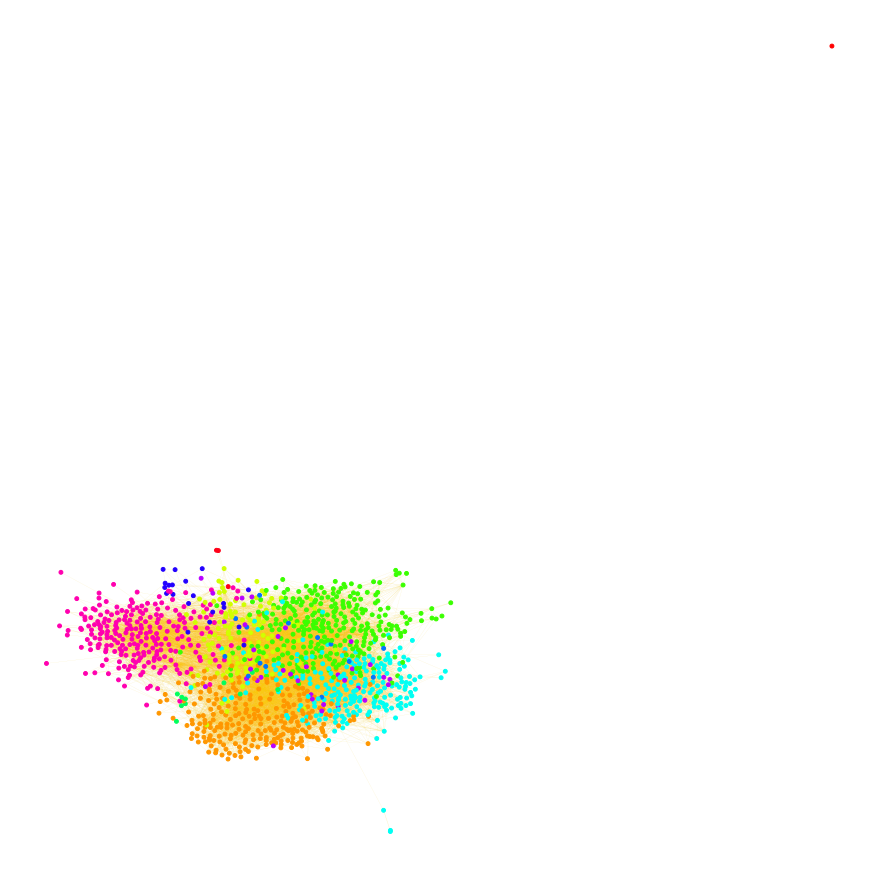

In [60]:
from fa2 import ForceAtlas2
import matplotlib.cm as cm

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_marvel_un, pos=None, iterations=500)

plt.figure(figsize=(12, 12))
# color the nodes according to their partition
cmap = cm.get_cmap('hsv', max(partition_marvel.values()) + 1)
nx.draw(G_marvel_un, pos=positions, with_labels=False, node_size=15, width=0.05, 
        cmap=cmap, node_color=list(partition_marvel.values()), edge_color='#f9c80e')
plt.show()

### Write a paragraph about your work to identify the communities. The paragraph should include

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

* Information about the algorithm you used to find communities.

For the community detection we are using the Louvain Algorithm. The algorithm, like many other community algorithms, is based on optimizing the modularity of the network. Modularity is a relative score from -0.5 to 1 that indicate how densely connected a number of nodes are linked together, relative to the expected number of links of a similar degree distributed random graph. A modularity higher than 0, indicate that a given group of nodes are more connected that one would expect if it was random, and therefor has the potential to represent a community. A combined modularity score of the graph can be found by adding and averaging over all detected communities, and the assumption is, that maximizing M over the entire graph provide the best parition of communities. 

The Louvains algorithm optimize for the highest modularity score in two repeated steps, after initiallity splittng the graph and assuming that each node belongs to its own community:
- 1: For each node, evaluate the gain in modularity if the node is placed in a communiy with one of its neigbhors, join the node where the modularity gain is maximized, and if non is gained, stay in the original community. Run untill no further improvements can be achieved.
- 2: Construct a new network where each node are the communities from step1, and the weight of the links between two nodes (that consist a number of nodes) are the sum of the links in the corresponding community. 

Step 1-2 is repeated untill no gain in maximum modularity is attained.

Like other algorithms based on modularity maximuzation, this approach "suffer" from the simplification that no node can be part of two communities, which in reality often is the case. An alternative approach would be to generate communities based on link clustering that allow nodes to be part of several communities.

* The value of modularity for your network.

The Marvel network has a modularity of 0.38 indicating the pressence of communities. 

* The number of communities and their sizes (in terms of number of nodes).


A total of 11 communities were detected in the Marvel universe
Community 0 has 202 nodes
Community 1 has 232 nodes
Community 3 has 292 nodes
Community 6 has 99 nodes
Community 10 has 238 nodes
Community 7 has 27 nodes
Community 5 has 27 nodes
Community 9 has 40 nodes
Community 2 has 13 nodes
Community 8 has 19 nodes
Community 4 has 1 nodes


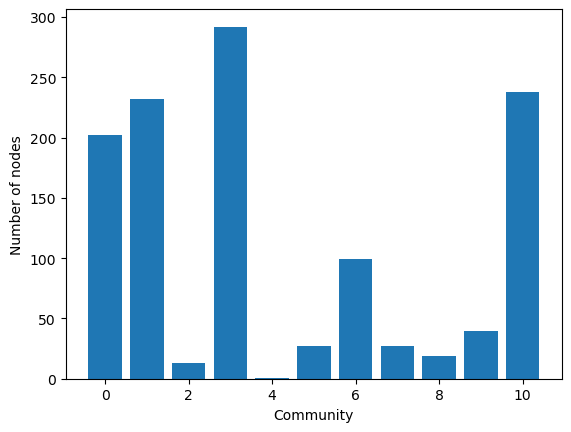

In [78]:
#number of communities detected
print(f'A total of {len(partition_list_marvel.keys())} communities were detected in the Marvel universe')
for comm in partition_list_marvel.keys():
    #sorted according to number of nodes
    print(f"Community {comm} has {len(partition_list_marvel[comm])} nodes")


import matplotlib.pyplot as plt
#plot bar chart of each community and the number of nodes in it sorted according to number of nodes in each community:
sorted_communities = sorted(partition_list_marvel.items(), key=lambda x: len(x[1]), reverse=True)
plt.bar([x[0] for x in sorted_communities], [len(x[1]) for x in sorted_communities])
plt.xlabel('Community')
plt.ylabel('Number of nodes')
plt.show()

The number of communities detected vary as the algorithm is run , but typically result in a total of 9-11 commmunities. A few large communities, typically with +200 nodes, make up a large proportion of the network. As seen from the commulitative plot below, roughly 90% of all nodes are included in the 5 largest communities. The remaining commmunities held a smaller number of nodes, typically 10-50, and a single community of just 1 node.

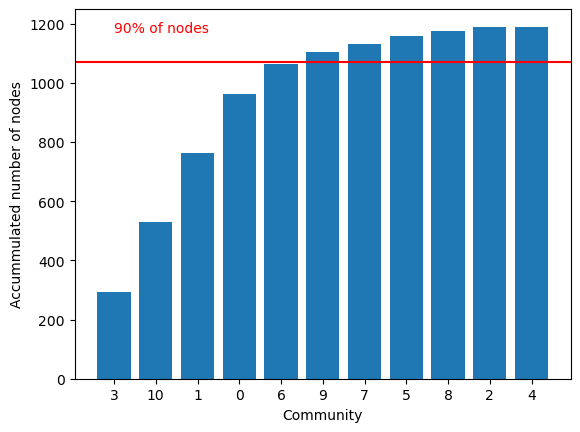

In [98]:
#plot a bar chart with the accumulated number of nodes in each community sorted according to number of nodes in each community:

plt.bar(([str(x[0]) for x in sorted_communities]), [sum([len(x[1]) for x in sorted_communities[:i+1]]) for i in range(len(sorted_communities))])
plt.xlabel('Community')
plt.ylabel('Accummulated number of nodes')
#add threshold at 90% of the total number of nodes
plt.axhline(y=0.9*len(G_marvel_un.nodes()), color='r', linestyle='-')
#add text at the threshold
plt.text(0, 0.9*len(G_marvel_un.nodes())+100, '90% of nodes', color='red')
plt.show()

### Task: For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.
(Week 7 - Part 6 - Exercise 5)

In [13]:
da

NameError: name 'da' is not defined

### Task: Then visualize the TF-IDF vectors using wordclouds (as described in Week 7). Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.
(Week 7 - Part 6 - Exercise 5)